#SCC5920 - Projeto Final (Mineração de Textos)

#Impacto de Representações Textuais em Modelos de Classificação de *Fake News*: Uma Abordagem Comparativa

Ada Maris Pereira Mário - 12725432

##Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
from wordcloud import WordCloud
!pip install umap-learn
import umap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

!pip install gensim
from gensim.models import KeyedVectors
!wget https://zenodo.org/api/files/ce27e83b-fa32-42a7-83bd-60f34ea1e318/GoogleNews-vectors-negative300.bin.gz
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

from transformers import DistilBertTokenizer, DistilBertModel
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Dados

In [ ]:
!wget https://zenodo.org/records/4561253/files/WELFake_Dataset.csv

--2024-10-28 01:49:48--  https://zenodo.org/records/4561253/files/WELFake_Dataset.csv
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245086152 (234M) [text/plain]
Saving to: ‘WELFake_Dataset.csv’

WELFake_Dataset.csv 100%[===================>] 233.73M  25.1MB/s    in 13s     

2024-10-28 01:50:01 (18.3 MB/s) - ‘WELFake_Dataset.csv’ saved [245086152/245086152]



In [ ]:
dataset = pd.read_csv('WELFake_Dataset.csv')

In [ ]:
dataset

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


### Amostragem, Train/Test Split e Tokenização

In [ ]:
def sample_dataset(df, n=5000):
  df_clean = df.dropna()

  class_0 = df_clean[df_clean['label'] == 0]
  class_1 = df_clean[df_clean['label'] == 1]

  # Retirar uma amostra balanceada de 5k para cada classe
  sample_class_0 = class_0.sample(n=n, random_state=42)
  sample_class_1 = class_1.sample(n=n, random_state=42)

  balanced_sample = pd.concat([sample_class_0, sample_class_1], axis=0)

  # Embaralhar as amostras para garantir distribuição aleatória
  balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

  return balanced_sample

sampled_dataset = sample_dataset(dataset)
print(sampled_dataset['label'].value_counts())

label
1    5000
0    5000
Name: count, dtype: int64


In [ ]:
sampled_dataset['combined'] = sampled_dataset['title'] + sampled_dataset['text']

In [ ]:
df_train, df_test = train_test_split(sampled_dataset, test_size=0.33, random_state=42)

In [ ]:
df_train

,Unnamed: 0,title,text,label,combined
8371,45796,CBS 60 Minutes Withheld Trump’s Appeal to ‘Sto...,J.R. Smith 21st Century WireThe election campa...,1,CBS 60 Minutes Withheld Trump’s Appeal to ‘Sto...
5027,6984,Nazis Whine Over Impending Release Of An Anti...,With the rise of Donald Trump has also come th...,1,Nazis Whine Over Impending Release Of An Anti...
9234,52798,U.S. reaffirms 'One China' policy to Beijing a...,WASHINGTON (Reuters) - The United States has b...,0,U.S. reaffirms 'One China' policy to Beijing a...
3944,6062,"Obama, Saudi prince focus on Iraq and Syria in...",WASHINGTON (Reuters) - President Barack Obama ...,0,"Obama, Saudi prince focus on Iraq and Syria in..."
6862,38504,Obama tries to limit fallout from British EU e...,"PALO ALTO, Calif. (Reuters) - U.S. President B...",0,Obama tries to limit fallout from British EU e...
...,...,...,...,...,...
5734,31040,"BREAKING: FBI Didn’t Record Hillary Interview,...",No worries FBI Director James Comey is has ass...,1,"BREAKING: FBI Didn’t Record Hillary Interview,..."
5191,35917,TREASON: This Election Fraud Goes All the Way ...,JS Mineset’s Bill Holter is back to help docum...,1,TREASON: This Election Fraud Goes All the Way ...
5390,40131,BUSTED! Wikileaks Emails Document Hillary Usin...,They published skewed polls in Michigan:,1,BUSTED! Wikileaks Emails Document Hillary Usin...
860,70724,JUDGE JEANINE RIPS DEMOCRATS: What Have Democr...,The truth is what you get with this judge! We ...,1,JUDGE JEANINE RIPS DEMOCRATS: What Have Democr...


In [ ]:
df_test

,Unnamed: 0,title,text,label,combined
6252,69193,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,,1,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...
4684,10329,¿Qué hacer si tu pareja se muda a tu piso?,¿Qué hacer si tu pareja se muda a tu piso? CON...,1,¿Qué hacer si tu pareja se muda a tu piso?¿Qué...
1731,50376,U.S. Air Campaign in Yemen Killed Guantánamo E...,"WASHINGTON — For a fifth consecutive night,...",0,U.S. Air Campaign in Yemen Killed Guantánamo E...
4742,11663,Memo to Trump: 'Action This Day!',"=> \n“In victory, magnanimity!” said Winston...",1,Memo to Trump: 'Action This Day!' => \n“In vi...
4521,33993,Victims of New Year’s Eve Migrant Attacks Come...,"Allegations of sexual harassment, theft, and a...",0,Victims of New Year’s Eve Migrant Attacks Come...
...,...,...,...,...,...
1744,56295,Cars torched in attack on French police housin...,"LYON, France (Reuters) - Attackers set fire to...",0,Cars torched in attack on French police housin...
9754,37491,TWO RICH WHITE GUYS Who Made A Fortune Selling...,Two white guys living in a state where 96% of ...,1,TWO RICH WHITE GUYS Who Made A Fortune Selling...
6094,57284,CHRISTIAN HIGH SCHOOL Told By State They Are N...,The drip drip drip of communism Leftists are s...,1,CHRISTIAN HIGH SCHOOL Told By State They Are N...
8781,27449,Gov. Chris Christie Bails On Cop’s Funeral To...,Governor Chris Christie wasted no time after s...,1,Gov. Chris Christie Bails On Cop’s Funeral To...


In [ ]:
def preprocess_text(text):
  # Remove caracteres especiais, números, etc.
  text = re.sub(r'\W', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.lower()  # Colocar tudo em minúsculas
  words = word_tokenize(text)  # Tokenizar o texto
  words = [word for word in words if word not in stopwords.words('english')]  # Remover stopwords
  return words

In [ ]:
df_train['processed'] = df_train['combined'].apply(preprocess_text)
df_test['processed'] = df_test['combined'].apply(preprocess_text)

## Word2Vec

In [ ]:
# gerar embeddings médios usando Word2Vec
def avg_w2v(df, model, embedding_dim=300):
  doc_embeddings = []

  for sentence in df['processed']:
    L = [model[token] for token in sentence if token in model]
    if L:  # Se houver palavras com embeddings
      embedding = np.mean(L, axis=0)
    else:  # Caso contrário, vetor de zeros
      embedding = np.zeros(embedding_dim)
    doc_embeddings.append(embedding)

  df['w2v_embeddings'] = doc_embeddings
  return df

df_train = avg_w2v(df_train, w2v, embedding_dim=300)
df_test = avg_w2v(df_test, w2v, embedding_dim=300)

##TF-IDF

In [ ]:
tfidf_train = df_train['processed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
tfidf_test = df_test['processed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(3,3))

tfidf_train = tfidf_vectorizer.fit_transform(tfidf_train)
tfidf_test = tfidf_vectorizer.transform(tfidf_test)

## SBERT

In [ ]:
model2 = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_train['bert_embeddings'] = list(model2.encode(df_train.combined.to_list()))
df_test['bert_embeddings'] = list(model2.encode(df_test.combined.to_list()))

##DistilBERT

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model = model.to(device)

def dbert_embeddings(texts):
  # Tokenizar o texto e mover as entradas para o dispositivo
  inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)

  # Desativar gradientes para não computar grad durante a inferência
  with torch.no_grad():
    outputs = model(**inputs)

  # Usamos o embedding do primeiro token [CLS]
  embeddings = outputs.last_hidden_state[:, 0, :]  # Primeira posição corresponde ao token [CLS]

  return embeddings.cpu()

df_train['distilbert_embeddings'] = df_train['combined'].apply(lambda x: dbert_embeddings([x]).squeeze().numpy())
df_test['distilbert_embeddings'] = df_test['combined'].apply(lambda x: dbert_embeddings([x]).squeeze().numpy())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Usando dispositivo: cuda


## Dataframes finais

In [ ]:
df_train

,Unnamed: 0,title,text,label,combined,processed,w2v_embeddings,bert_embeddings,distilbert_embeddings
8371,45796,CBS 60 Minutes Withheld Trump’s Appeal to ‘Sto...,J.R. Smith 21st Century WireThe election campa...,1,CBS 60 Minutes Withheld Trump’s Appeal to ‘Sto...,"[cbs, 60, minutes, withheld, trump, appeal, st...","[0.023222066, 0.039201505, 0.020232925, 0.0583...","[-0.060425516, -0.1700207, 0.06263854, -0.2417...","[-0.14368342, -0.31305584, -0.25921246, -0.001..."
5027,6984,Nazis Whine Over Impending Release Of An Anti...,With the rise of Donald Trump has also come th...,1,Nazis Whine Over Impending Release Of An Anti...,"[nazis, whine, impending, release, anti, nazi,...","[0.045822732, 0.015975868, 0.02981795, 0.12603...","[-0.044678792, -0.16230123, -0.44847435, -0.16...","[0.11451271, -0.16744953, -0.17341222, 0.03323..."
9234,52798,U.S. reaffirms 'One China' policy to Beijing a...,WASHINGTON (Reuters) - The United States has b...,0,U.S. reaffirms 'One China' policy to Beijing a...,"[u, reaffirms, one, china, policy, beijing, tr...","[-0.04939158, 0.0619435, 0.03876989, 0.0789207...","[-0.37544018, 0.13743855, 0.15728568, -0.03558...","[-0.14155468, -0.13919301, -0.23807706, -0.015..."
3944,6062,"Obama, Saudi prince focus on Iraq and Syria in...",WASHINGTON (Reuters) - President Barack Obama ...,0,"Obama, Saudi prince focus on Iraq and Syria in...","[obama, saudi, prince, focus, iraq, syria, was...","[-0.014560968, 0.05140066, 0.022810921, 0.0683...","[0.043612793, 0.353248, 0.09905648, -0.2880794...","[-0.20759249, -0.17778324, -0.37519014, -0.127..."
6862,38504,Obama tries to limit fallout from British EU e...,"PALO ALTO, Calif. (Reuters) - U.S. President B...",0,Obama tries to limit fallout from British EU e...,"[obama, tries, limit, fallout, british, eu, ex...","[-0.010468794, 0.045371063, 0.01696114, 0.1035...","[0.26868117, 0.25612703, 0.12910405, -0.376321...","[-0.20344795, -0.29624802, -0.14002576, 0.0155..."
...,...,...,...,...,...,...,...,...,...
5734,31040,"BREAKING: FBI Didn’t Record Hillary Interview,...",No worries FBI Director James Comey is has ass...,1,"BREAKING: FBI Didn’t Record Hillary Interview,...","[breaking, fbi, record, hillary, interview, ma...","[0.0026911313, 0.032417577, 0.02252394, 0.0309...","[-0.10257532, -0.32357496, -0.062387206, 0.093...","[-0.30544564, -0.238163, -0.29383785, -0.10202..."
5191,35917,TREASON: This Election Fraud Goes All the Way ...,JS Mineset’s Bill Holter is back to help docum...,1,TREASON: This Election Fraud Goes All the Way ...,"[treason, election, fraud, goes, way, top, bil...","[0.02783003, 0.07454994, 0.0042626117, 0.07679...","[-0.0654437, -0.52956444, -0.24165456, -0.1876...","[-0.0032564453, -0.2470698, -0.29676384, 0.066..."
5390,40131,BUSTED! Wikileaks Emails Document Hillary Usin...,They published skewed polls in Michigan:,1,BUSTED! Wikileaks Emails Document Hillary Usin...,"[busted, wikileaks, emails, document, hillary,...","[0.057551794, 0.04057421, -0.01020159, 0.07933...","[-0.4166148, -0.48208392, -0.35939175, 0.38025...","[-0.07501688, -0.19766882, -0.26230252, 0.0364..."
860,70724,JUDGE JEANINE RIPS DEMOCRATS: What Have Democr...,The truth is what you get with this judge! We ...,1,JUDGE JEANINE RIPS DEMOCRATS: What Have Democr...,"[judge, jeanine, rips, democrats, democrats, d...","[0.06746129, -0.0073525566, -0.0019182478, 0.1...","[-0.17898986, 0.27033013, -0.14320305, 0.15983...","[-0.23599756, -0.33088395, -0.28145584, -0.054..."


In [ ]:
df_test

,Unnamed: 0,title,text,label,combined,processed,w2v_embeddings,bert_embeddings,distilbert_embeddings
6252,69193,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,,1,(VIDEO) JUDGE NAPOLITANO FILLS US IN ON ORDER ...,"[video, judge, napolitano, fills, us, order, r...","[0.023596192, 0.12244568, -0.022953797, 0.1067...","[-0.27256355, -0.011067676, -0.38805458, -0.54...","[0.015818547, -0.21393192, 0.10250761, 0.22495..."
4684,10329,¿Qué hacer si tu pareja se muda a tu piso?,¿Qué hacer si tu pareja se muda a tu piso? CON...,1,¿Qué hacer si tu pareja se muda a tu piso?¿Qué...,"[qué, hacer, si, tu, pareja, se, muda, tu, pis...","[-0.047740363, 0.047331195, 0.1360238, 0.10444...","[-0.26109076, 0.2643187, 0.20584401, -0.172081...","[-0.3605017, -0.13889001, 0.104272865, -0.0643..."
1731,50376,U.S. Air Campaign in Yemen Killed Guantánamo E...,"WASHINGTON — For a fifth consecutive night,...",0,U.S. Air Campaign in Yemen Killed Guantánamo E...,"[u, air, campaign, yemen, killed, guantánamo, ...","[0.020159682, 0.05681218, 0.0485892, 0.0511016...","[-0.095626086, 0.15210369, -0.4009175, -0.2904...","[-0.19136705, -0.20884584, -0.41768053, -0.231..."
4742,11663,Memo to Trump: 'Action This Day!',"=> \n“In victory, magnanimity!” said Winston...",1,Memo to Trump: 'Action This Day!' => \n“In vi...,"[memo, trump, action, day, victory, magnanimit...","[0.012165258, 0.057427403, 0.035035703, 0.0956...","[0.1583077, 0.12640063, 0.11623954, -0.0631768...","[-0.1789479, -0.22501206, -0.2006702, -0.03808..."
4521,33993,Victims of New Year’s Eve Migrant Attacks Come...,"Allegations of sexual harassment, theft, and a...",0,Victims of New Year’s Eve Migrant Attacks Come...,"[victims, new, year, eve, migrant, attacks, co...","[0.04102264, 0.046670858, 0.025216645, 0.02795...","[0.46785128, 0.32419094, -0.045415826, -0.2640...","[-0.016292622, -0.037092615, 0.02102054, -0.30..."
...,...,...,...,...,...,...,...,...,...
1744,56295,Cars torched in attack on French police housin...,"LYON, France (Reuters) - Attackers set fire to...",0,Cars torched in attack on French police housin...,"[cars, torched, attack, french, police, housin...","[0.085182294, 0.046907343, 0.042229693, 0.0230...","[-0.1204904, 0.3685282, -0.12819044, -0.115059...","[-0.12457907, -0.32358867, -0.20679456, -0.301..."
9754,37491,TWO RICH WHITE GUYS Who Made A Fortune Selling...,Two white guys living in a state where 96% of ...,1,TWO RICH WHITE GUYS Who Made A Fortune Selling...,"[two, rich, white, guys, made, fortune, sellin...","[0.01790815, 0.03061732, -0.004927127, 0.09040...","[-0.062123466, 0.39778894, -0.16015244, -0.034...","[-0.032034963, -0.3371928, -0.035908174, -0.05..."
6094,57284,CHRISTIAN HIGH SCHOOL Told By State They Are N...,The drip drip drip of communism Leftists are s...,1,CHRISTIAN HIGH SCHOOL Told By State They Are N...,"[christian, high, school, told, state, longer,...","[0.006256181, 0.015381504, 0.046641782, 0.1014...","[0.09114568, -0.025953166, -0.15568249, -0.348...","[-0.1729571, -0.16699435, -0.12309272, -0.0961..."
8781,27449,Gov. Chris Christie Bails On Cop’s Funeral To...,Governor Chris Christie wasted no time after s...,1,Gov. Chris Christie Bails On Cop’s Funeral To...,"[gov, chris, christie, bails, cop, funeral, ca...","[0.02011347, 0.041390732, 0.008324501, 0.05681...","[-0.10212298, 0.2899587, -0.20244898, 0.085068...","[-0.32640707, -0.3729426, -0.040747438, -0.076..."


##Padronização

In [ ]:
scaler = StandardScaler().fit(tfidf_train.toarray())
tfidf_train = scaler.transform(tfidf_train.toarray())
tfidf_test = scaler.transform(tfidf_test.toarray())

scaler = StandardScaler().fit(df_train.w2v_embeddings.to_list())
w2v_train = scaler.transform(df_train.w2v_embeddings.to_list())
w2v_test = scaler.transform(df_test.w2v_embeddings.to_list())

scaler = StandardScaler().fit(df_train.bert_embeddings.to_list())
bert_train = scaler.transform(df_train.bert_embeddings.to_list())
bert_test = scaler.transform(df_test.bert_embeddings.to_list())

scaler = StandardScaler().fit(df_train.distilbert_embeddings.to_list())
distilbert_train = scaler.transform(df_train.distilbert_embeddings.to_list())
distilbert_test = scaler.transform(df_test.distilbert_embeddings.to_list())

##EDA

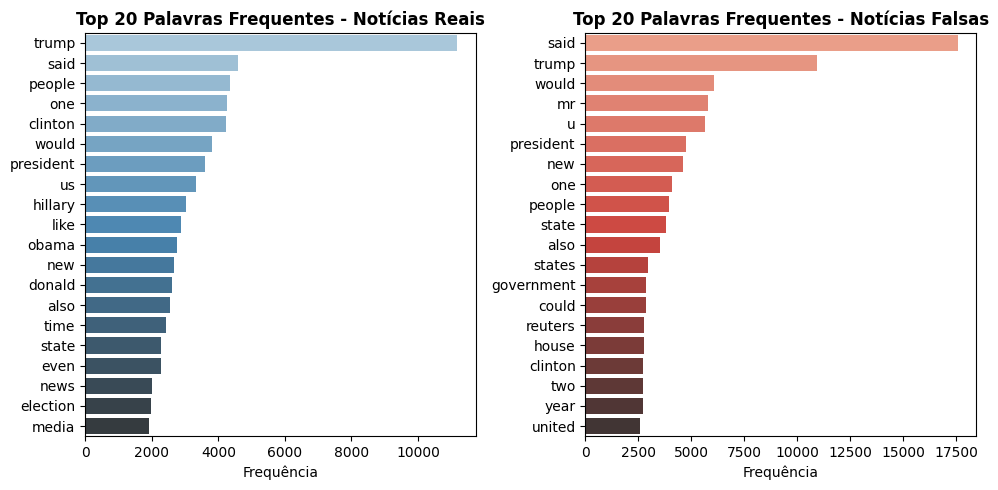

In [ ]:
df_real = df_train[df_train['label'] == 1]
df_fake = df_train[df_train['label'] == 0]

words_real = [word for text in df_real['processed'] for word in text]
word_freq_real = Counter(words_real).most_common(20)

words_fake = [word for text in df_fake['processed'] for word in text]
word_freq_fake = Counter(words_fake).most_common(20)

wreal, counts_real = zip(*word_freq_real)
wfake, counts_fake = zip(*word_freq_fake)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=counts_real, y=wreal, hue=wreal, palette='Blues_d', ax=axs[0], legend=False)
axs[0].set_title('Top 20 Palavras Frequentes - Notícias Reais', fontweight='bold', fontsize=12)
axs[0].set_xlabel('Frequência')
# axs[0].set_ylabel('Palavras')

sns.barplot(x=counts_fake, y=wfake, hue=wfake, palette='Reds_d', ax=axs[1], legend=False)
axs[1].set_title('Top 20 Palavras Frequentes - Notícias Falsas', fontweight='bold', fontsize=12)
axs[1].set_xlabel('Frequência')
# axs[1].set_ylabel('Palavras')

plt.tight_layout()
plt.show()

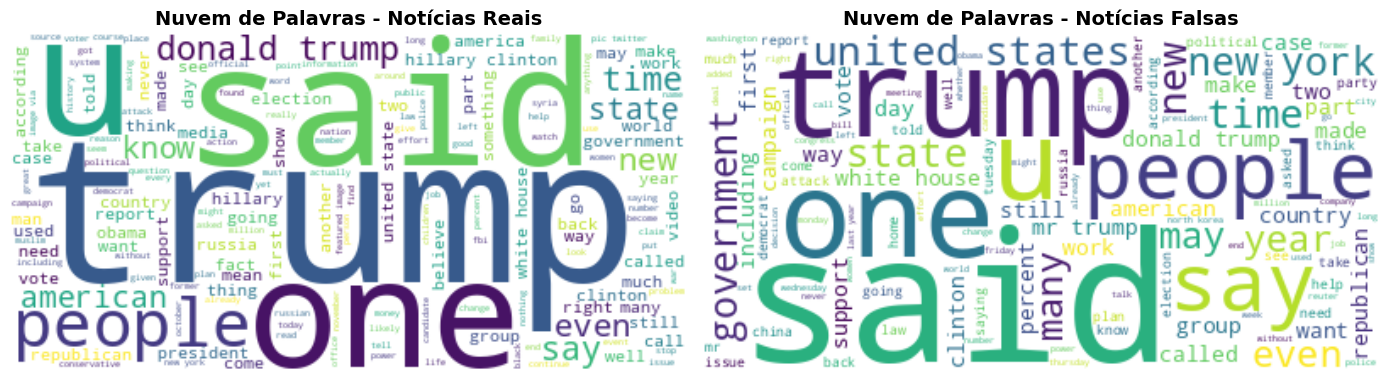

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

wordcloud_real = WordCloud(background_color='white').generate(' '.join(words_real))
axs[0].imshow(wordcloud_real, interpolation='bilinear')
axs[0].axis("off")
axs[0].set_title('Nuvem de Palavras - Notícias Reais', fontweight='bold', fontsize=14)

wordcloud_fake = WordCloud(background_color='white').generate(' '.join(words_fake))
axs[1].imshow(wordcloud_fake, interpolation='bilinear')
axs[1].axis("off")
axs[1].set_title('Nuvem de Palavras - Notícias Falsas', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

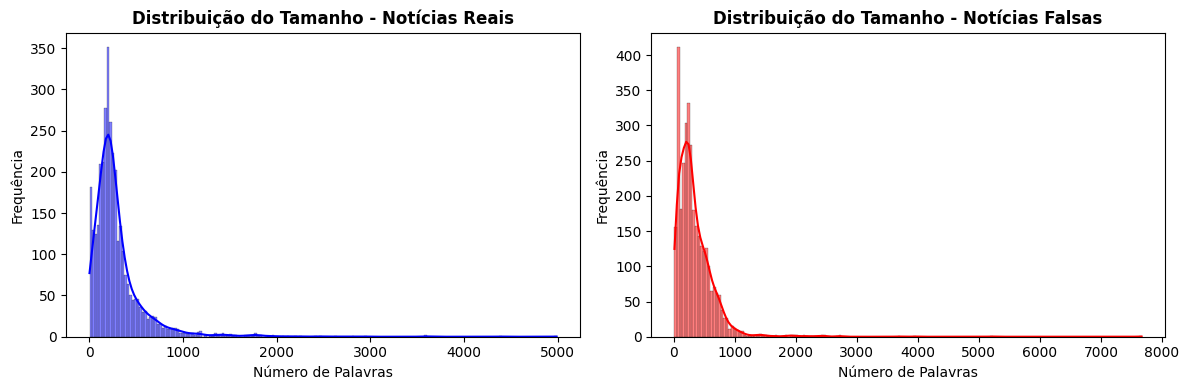

In [ ]:
real_lengths = df_real['processed'].apply(len)
fake_lengths = df_fake['processed'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(real_lengths, color='blue', ax=axs[0], kde=True)
axs[0].set_title('Distribuição do Tamanho - Notícias Reais', fontweight='bold', fontsize=12)
axs[0].set_xlabel('Número de Palavras')
axs[0].set_ylabel('Frequência')

sns.histplot(fake_lengths, color='red', ax=axs[1], kde=True)
axs[1].set_title('Distribuição do Tamanho - Notícias Falsas', fontweight='bold', fontsize=12)
axs[1].set_xlabel('Número de Palavras')
axs[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

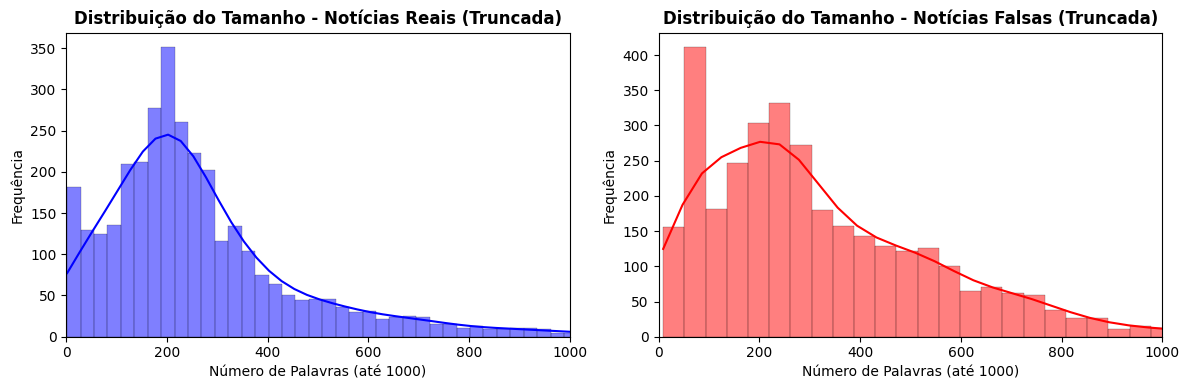

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(real_lengths, color='blue', ax=axs[0], kde=True)
axs[0].set_title('Distribuição do Tamanho - Notícias Reais (Truncada)', fontweight='bold', fontsize=12)
axs[0].set_xlim([0, 1000])
axs[0].set_xlabel('Número de Palavras (até 1000)')
axs[0].set_ylabel('Frequência')

sns.histplot(fake_lengths, color='red', ax=axs[1], kde=True)
axs[1].set_title('Distribuição do Tamanho - Notícias Falsas (Truncada)', fontweight='bold', fontsize=12)
axs[1].set_xlim([0, 1000])
axs[1].set_xlabel('Número de Palavras (até 1000)')
axs[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [ ]:
def apply_pca(embeddings, n_components=3):
  pca = PCA(n_components=n_components)
  reduced_embeddings = pca.fit_transform(embeddings)
  return reduced_embeddings, pca

tfidf_pca, tfidf_pca_model = apply_pca(tfidf_train)

w2v_pca, w2v_pca_model = apply_pca(w2v_train)

bert_pca, bert_pca_model = apply_pca(bert_train)

distilbert_pca, distilbert_pca_model = apply_pca(distilbert_train)

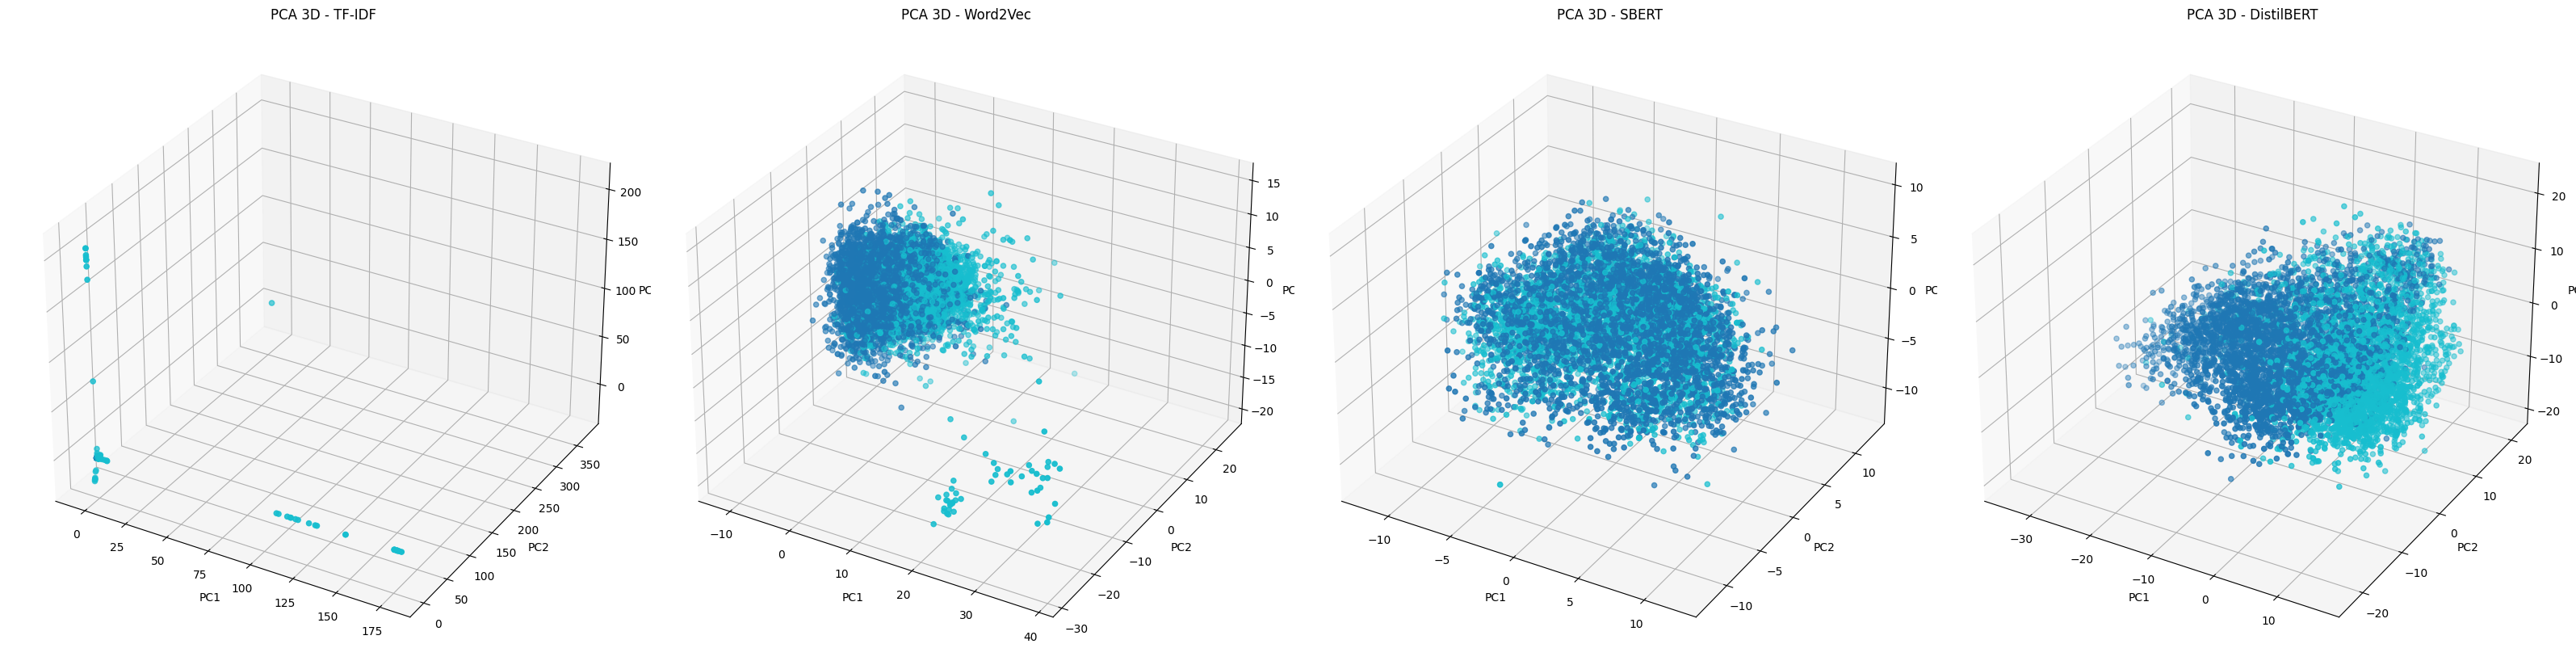

In [ ]:
fig = plt.figure(figsize=(32, 48))

ax1 = fig.add_subplot(141, projection='3d')
ax1.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], tfidf_pca[:, 2], c=df_train['label'], cmap='tab10')
ax1.set_title("PCA 3D - TF-IDF")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

ax2 = fig.add_subplot(142, projection='3d')
ax2.scatter(w2v_pca[:, 0], w2v_pca[:, 1], w2v_pca[:, 2], c=df_train['label'], cmap='tab10')
ax2.set_title("PCA 3D - Word2Vec")
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

ax3 = fig.add_subplot(143, projection='3d')
ax3.scatter(bert_pca[:, 0], bert_pca[:, 1], bert_pca[:, 2], c=df_train['label'], cmap='tab10')
ax3.set_title("PCA 3D - SBERT")
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')

ax4 = fig.add_subplot(144, projection='3d')
ax4.scatter(distilbert_pca[:, 0], distilbert_pca[:, 1], distilbert_pca[:, 2], c=df_train['label'], cmap='tab10')
ax4.set_title("PCA 3D - DistilBERT")
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
ax4.set_zlabel('PC3')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridd

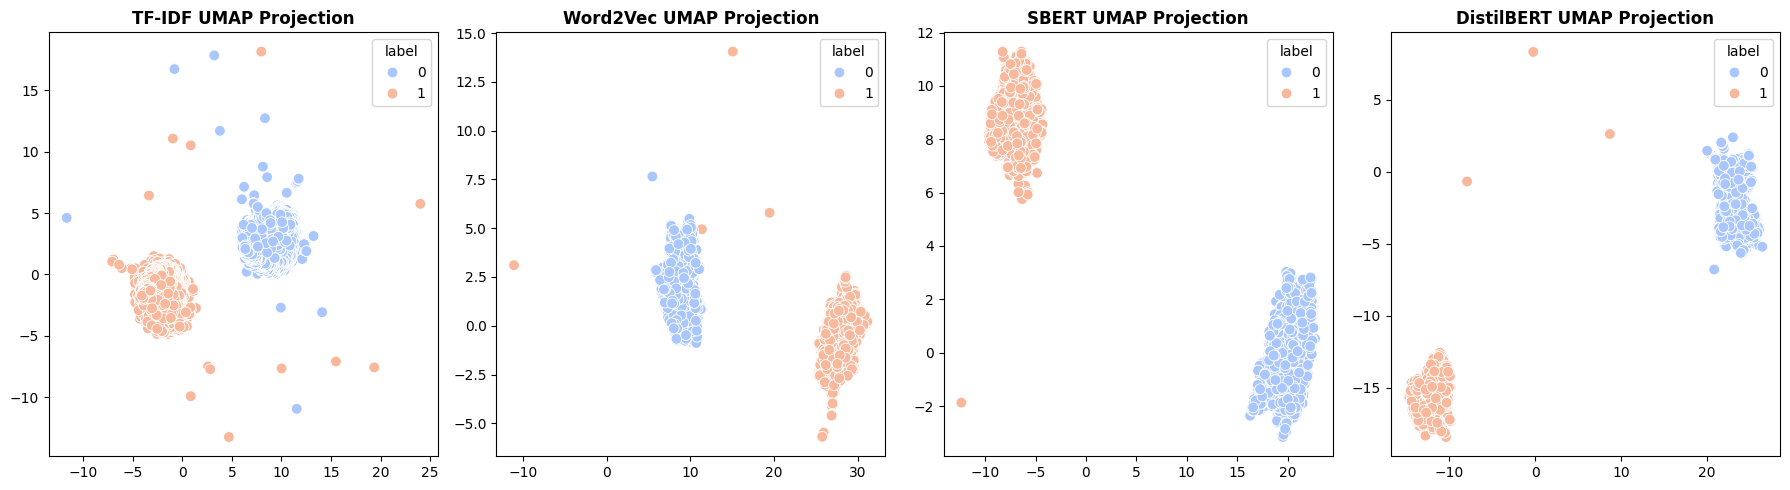

In [ ]:
def umap_projection(X, y, title, n_neighbors=16, min_dist=0.1, n_components=2):
  umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
  X_umap = umap_model.fit_transform(X, y)
  return X_umap

y = df_train['label']
X_tfidf_umap = umap_projection(tfidf_train, y, "TF-IDF")
X_w2v_umap = umap_projection(w2v_train, y, "Word2Vec")
X_sbert_umap = umap_projection(bert_train, y, "SBERT")
X_distilbert_umap = umap_projection(distilbert_train, y, "DistilBERT")

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.scatterplot(x=X_tfidf_umap[:, 0], y=X_tfidf_umap[:, 1], hue=y, palette='coolwarm', s=60, ax=axes[0])
axes[0].set_title("TF-IDF UMAP Projection", fontweight="bold")

sns.scatterplot(x=X_w2v_umap[:, 0], y=X_w2v_umap[:, 1], hue=y, palette='coolwarm', s=60, ax=axes[1])
axes[1].set_title("Word2Vec UMAP Projection", fontweight="bold")

sns.scatterplot(x=X_sbert_umap[:, 0], y=X_sbert_umap[:, 1], hue=y, palette='coolwarm', s=60, ax=axes[2])
axes[2].set_title("SBERT UMAP Projection", fontweight="bold")

sns.scatterplot(x=X_distilbert_umap[:, 0], y=X_distilbert_umap[:, 1], hue=y, palette='coolwarm', s=60, ax=axes[3])
axes[3].set_title("DistilBERT UMAP Projection", fontweight="bold")

plt.tight_layout()
plt.show()


## KNN

###TF-IDF

In [ ]:
# identificação dos melhores parâmetros para o knn neste problema
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'metric': ['euclidean', 'minkowski','manhattan', 'cosine']}]

model = GridSearchCV(knn, param_grid)

model.fit(tfidf_train, df_train['label'])
print(model.best_params_)
model.score(tfidf_train, df_train['label'])

{'metric': 'cosine', 'n_neighbors': 17}


0.8583582089552239

In [ ]:
knn = KNeighborsClassifier(n_neighbors=17,metric="cosine", weights='distance')
knn.fit(tfidf_train, df_train['label'])
y_pred = knn.predict(tfidf_test)
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
print(classification_report(df_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1680
           1       0.83      0.87      0.85      1620

    accuracy                           0.84      3300
   macro avg       0.85      0.85      0.84      3300
weighted avg       0.85      0.84      0.84      3300



In [ ]:
scores = cross_val_score(knn, tfidf_test, df_test['label'])
print(scores)
print(scores.mean())

[0.82272727 0.81363636 0.83787879 0.75151515 0.75606061]
0.7963636363636363


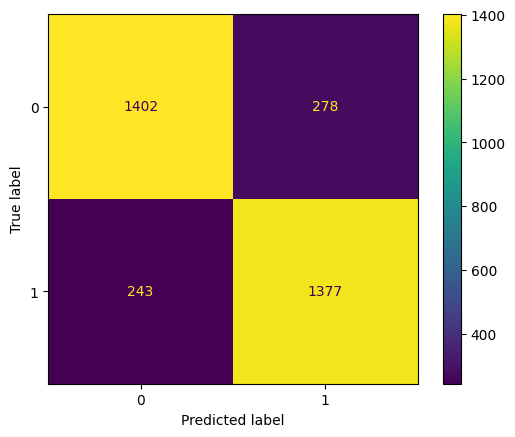

In [ ]:
cm = confusion_matrix(df_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

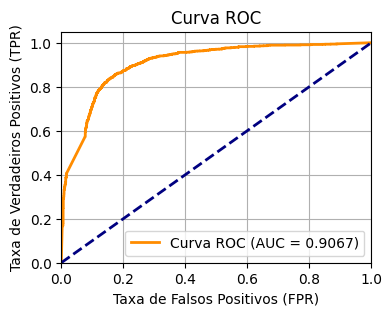

In [ ]:
y_score = knn.predict_proba(tfidf_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
tfidf_scores = [
    round(accuracy_score(df_test['label'], y_pred), 4),
    round(precision_score(df_test['label'], y_pred), 4),
    round(recall_score(df_test['label'], y_pred), 4),
    round(f1_score(df_test['label'], y_pred), 4),
    round(roc_auc_score(df_test['label'], knn.predict_proba(tfidf_test)[:, 1]), 4)
]

###W2V

In [ ]:
# identificação dos melhores parâmetros para o knn neste problema
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'minkowski','manhattan','chebyshev', 'cosine']}]

model = GridSearchCV(knn, param_grid)

model.fit(w2v_train, df_train['label'])
print(model.best_params_)
model.score(w2v_train, df_train['label'])

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'metric': 'cosine', 'n_neighbors': 19, 'weights': 'distance'}


1.0

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19,metric="cosine", weights='distance')
knn.fit(w2v_train, df_train['label'])
y_pred = knn.predict(w2v_test)
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
print(classification_report(df_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1680
           1       0.87      0.79      0.83      1620

    accuracy                           0.84      3300
   macro avg       0.84      0.84      0.84      3300
weighted avg       0.84      0.84      0.84      3300



In [ ]:
scores = cross_val_score(knn, w2v_test, df_test['label'])
print(scores)
print(scores.mean())

[0.83181818 0.80606061 0.83484848 0.8        0.79090909]
0.8127272727272727


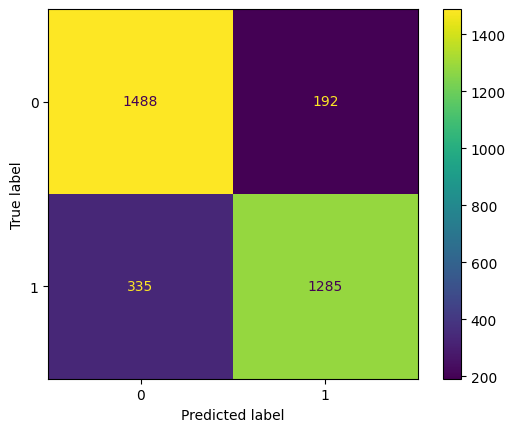

In [ ]:
cm = confusion_matrix(df_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

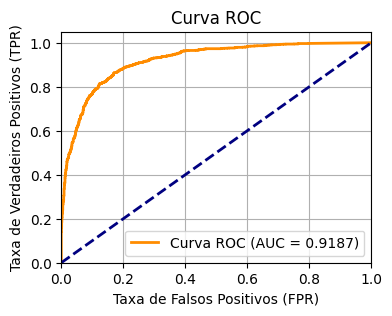

In [ ]:
y_score = knn.predict_proba(w2v_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
w2v_scores = [
    round(accuracy_score(df_test['label'], y_pred), 4),
    round(precision_score(df_test['label'], y_pred), 4),
    round(recall_score(df_test['label'], y_pred), 4),
    round(f1_score(df_test['label'], y_pred), 4),
    round(roc_auc_score(df_test['label'], knn.predict_proba(w2v_test)[:, 1]), 4)
]

###SBert

In [ ]:
# identificação dos melhores parâmetros para o knn neste problema
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'minkowski','manhattan','chebyshev', 'cosine']}]

model = GridSearchCV(knn, param_grid)

model.fit(bert_train, df_train['label'])
print(model.best_params_)
model.score(bert_train, df_train['label'])

{'metric': 'cosine', 'n_neighbors': 18, 'weights': 'distance'}


1.0

In [ ]:
knn = KNeighborsClassifier(n_neighbors=18,metric="cosine", weights='distance')
knn.fit(bert_train, df_train['label'])
y_pred = knn.predict(bert_test)
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
print(classification_report(df_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1680
           1       0.84      0.80      0.82      1620

    accuracy                           0.83      3300
   macro avg       0.83      0.83      0.83      3300
weighted avg       0.83      0.83      0.83      3300



In [ ]:
scores = cross_val_score(knn, bert_test, df_test['label'])
print(scores)
print(scores.mean())

[0.80454545 0.78181818 0.81515152 0.81060606 0.80606061]
0.8036363636363635


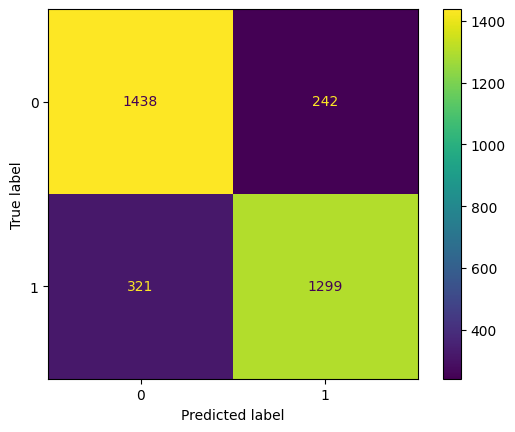

In [ ]:
cm = confusion_matrix(df_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

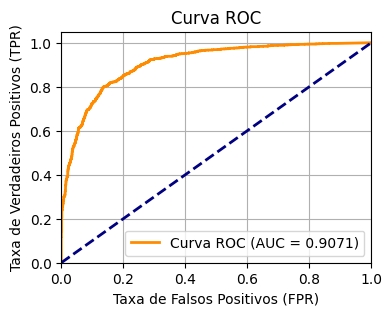

In [ ]:
y_score = knn.predict_proba(bert_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
sbert_scores = [
    round(accuracy_score(df_test['label'], y_pred), 4),
    round(precision_score(df_test['label'], y_pred), 4),
    round(recall_score(df_test['label'], y_pred), 4),
    round(f1_score(df_test['label'], y_pred), 4),
    round(roc_auc_score(df_test['label'], knn.predict_proba(bert_test)[:, 1]), 4)
]

###DistilBERT

In [ ]:
# identificação dos melhores parâmetros para o knn neste problema
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': np.arange(1, 21),
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'minkowski','manhattan','chebyshev', 'cosine']}]

model = GridSearchCV(knn, param_grid)

model.fit(distilbert_train, df_train['label'])
print(model.best_params_)
model.score(distilbert_train, df_train['label'])

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


1.0

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10,metric="manhattan", weights='distance')
knn.fit(distilbert_train, df_train['label'])
y_pred = knn.predict(distilbert_test)
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
print(classification_report(df_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1680
           1       0.92      0.87      0.89      1620

    accuracy                           0.90      3300
   macro avg       0.90      0.89      0.89      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
scores = cross_val_score(knn, distilbert_test, df_test['label'])
print(scores)
print(scores.mean())

[0.88787879 0.86969697 0.88484848 0.88939394 0.88484848]
0.8833333333333334


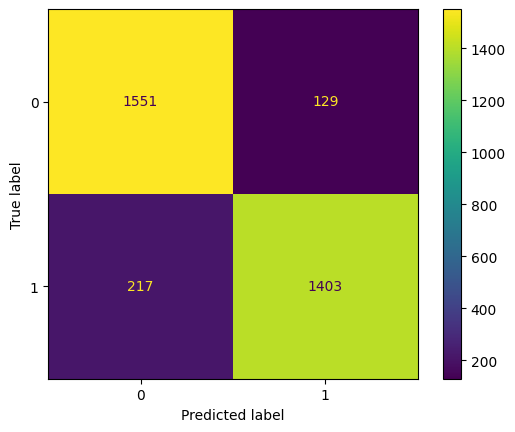

In [ ]:
cm = confusion_matrix(df_test['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

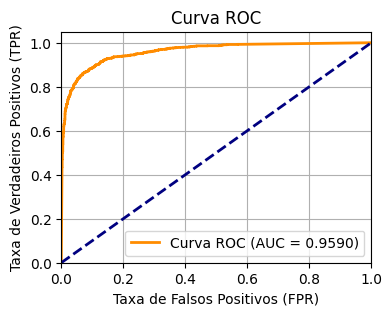

In [ ]:
y_score = knn.predict_proba(distilbert_test)[:, 1]

fpr, tpr, thresholds = roc_curve(df_test['label'], y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#dados que serão utilizados para wilcoxon
distilbert_scores = [
    round(accuracy_score(df_test['label'], y_pred), 4),
    round(precision_score(df_test['label'], y_pred), 4),
    round(recall_score(df_test['label'], y_pred), 4),
    round(f1_score(df_test['label'], y_pred), 4),
    round(roc_auc_score(df_test['label'], knn.predict_proba(distilbert_test)[:, 1]), 4)
]

##Teste de Wilcoxon para dados pareados

In [ ]:
print("tfidf_scores:", tfidf_scores)
print("w2v_scores:", w2v_scores)
print("sbert_scores:", sbert_scores)
print("distilbert_scores:", distilbert_scores)

tfidf_scores: [0.8394, 0.8303, 0.8457, 0.8379, 0.9067]
w2v_scores: [0.8403, 0.87, 0.7932, 0.8298, 0.9187]
sbert_scores: [0.8294, 0.843, 0.8019, 0.8219, 0.9071]
distilbert_scores: [0.8952, 0.9158, 0.866, 0.8902, 0.959]


In [ ]:
# considerando a ordem dos termos nas linhas dos prints, temos que o modelo da direita ("grupo tratamento")
# é o que está sendo testado ter desempenho maior (>) que o da esquerda ("grupo controle")
from scipy.stats import wilcoxon
print('tfidf x w2v:', wilcoxon(w2v_scores, tfidf_scores, alternative='greater'))
print('tfidf x sbert:', wilcoxon(sbert_scores, tfidf_scores, alternative='greater'))
print('tfidf x distilbert:', wilcoxon(distilbert_scores, tfidf_scores, alternative='greater'))
print('w2v x sbert:', wilcoxon(sbert_scores, w2v_scores, alternative='greater'))
print('w2v x distilbert:', wilcoxon(distilbert_scores, w2v_scores, alternative='greater'))
print('sbert x distilbert:', wilcoxon(distilbert_scores, sbert_scores, alternative='greater'))

tfidf x w2v: WilcoxonResult(statistic=8.0, pvalue=0.5)
tfidf x sbert: WilcoxonResult(statistic=4.0, pvalue=0.84375)
tfidf x distilbert: WilcoxonResult(statistic=15.0, pvalue=0.03125)
w2v x sbert: WilcoxonResult(statistic=2.0, pvalue=0.9375)
w2v x distilbert: WilcoxonResult(statistic=15.0, pvalue=0.03125)
sbert x distilbert: WilcoxonResult(statistic=15.0, pvalue=0.03125)


In [ ]:
# testes bônus mas não inclusos no relatório
print('tfidf x w2v:', wilcoxon(w2v_scores, tfidf_scores, alternative='less'))
print('tfidf x sbert:', wilcoxon(sbert_scores, tfidf_scores, alternative='less'))
print('tfidf x distilbert:', wilcoxon(distilbert_scores, tfidf_scores, alternative='less'))
print('w2v x sbert:', wilcoxon(sbert_scores, w2v_scores, alternative='less'))
print('w2v x distilbert:', wilcoxon(distilbert_scores, w2v_scores, alternative='less'))
print('sbert x distilbert:', wilcoxon(distilbert_scores, sbert_scores, alternative='less'))

tfidf x w2v: WilcoxonResult(statistic=8.0, pvalue=0.59375)
tfidf x sbert: WilcoxonResult(statistic=4.0, pvalue=0.21875)
tfidf x distilbert: WilcoxonResult(statistic=15.0, pvalue=1.0)
w2v x sbert: WilcoxonResult(statistic=2.0, pvalue=0.09375)
w2v x distilbert: WilcoxonResult(statistic=15.0, pvalue=1.0)
sbert x distilbert: WilcoxonResult(statistic=15.0, pvalue=1.0)
